# DETR concept: https://www.youtube.com/watch?v=T35ba_VXkMY

In [ ]:
!unzip -q /content/bone_fracture_dataset.zip -d /content/bone_fracture_dataset

In [ ]:
!python -m pip install --upgrade pip --quiet
!pip install supervision==0.10.0 transformers pytorch-lightning timm albumentations --quiet
!pip install cython pycocotools scipy roboflow --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 175.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 178.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 176.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import torchvision
import pytorch_lightning as pl
import supervision as sv
import transformers
import albumentations as A
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"PyTorch Version: {torch.__version__}")
print(f"Supervision Version: {sv.__version__}")
print(f"Transformers Version: {transformers.__version__}")
print(f"PyTorch Lightning Version: {pl.__version__}")

PyTorch Version: 2.6.0+cu124
Supervision Version: 0.10.0
Transformers Version: 4.52.4
PyTorch Lightning Version: 2.5.1.post0


# Data Processing with Augmentations

In [ ]:
DATASET_PATH = "/content/bone_fracture_dataset"
ANNOTATION_FILE_NAME = "_annotations.coco.json"
TRAIN_DIRECTORY = os.path.join(DATASET_PATH, "train")
VAL_DIRECTORY = os.path.join(DATASET_PATH, "valid")
TEST_DIRECTORY = os.path.join(DATASET_PATH, "test")

image_processor = transformers.DetrImageProcessor.from_pretrained(
    "facebook/detr-resnet-50"
)

TRAIN_TRANSFORM = A.Compose(
    [
        A.RandomSizedBBoxSafeCrop(width=480, height=480, erosion_rate=0.2),
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(p=0.3),
        A.Blur(p=0.2),
    ],
    bbox_params=A.BboxParams(
        format="coco", label_fields=["class_labels"]
    ),
)

class CocoDetectionAugmented(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        image_directory_path: str,
        image_processor,
        transform=None,
    ):
        annotation_file_path = os.path.join(
            image_directory_path, ANNOTATION_FILE_NAME
        )
        super().__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor
        self.transform = transform

    def __getitem__(self, idx):
        image, coco_annotations = super().__getitem__(idx)
        image_id = self.ids[idx]

        # Prepare data for albumentations
        image_np = np.array(image)
        bboxes = [ann["bbox"] for ann in coco_annotations]
        class_labels = [ann["category_id"] for ann in coco_annotations]

        if self.transform:
            transformed = self.transform(
                image=image_np, bboxes=bboxes, class_labels=class_labels
            )
            image_np = transformed["image"]
            bboxes = transformed["bboxes"]
            class_labels = transformed["class_labels"]

        # Reformat annotations for the DETR processor
        annotations = []
        for bbox, label in zip(bboxes, class_labels):
            x, y, w, h = bbox
            annotations.append(
                {
                    "bbox": [x, y, w, h],
                    "category_id": label,
                    "area": w * h,
                }
            )

        # Process with Hugging Face processor
        processed = self.image_processor(
            images=image_np,
            annotations={
                "image_id": image_id,
                "annotations": annotations,
            },
            return_tensors="pt",
        )
        pixel_values = processed["pixel_values"].squeeze()
        target = processed["labels"][0]

        return pixel_values, target

TRAIN_DATASET = CocoDetectionAugmented(
    image_directory_path=TRAIN_DIRECTORY,
    image_processor=image_processor,
    transform=TRAIN_TRANSFORM,
)
VAL_DATASET = CocoDetectionAugmented(
    image_directory_path=VAL_DIRECTORY, image_processor=image_processor
)
TEST_DATASET = CocoDetectionAugmented(
    image_directory_path=TEST_DIRECTORY, image_processor=image_processor
)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))

preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of training examples: 326
Number of validation examples: 88
Number of test examples: 44


This code block defines a **custom COCO dataset loader with data augmentation**, specifically tailored for training a **DETR (DEtection TRansformer)** object detection model using the Hugging Face `transformers` library and the Albumentations library for augmentations.

Let’s break it down step by step:

---

## 🔧 1. **Dataset Paths**

```python
DATASET_PATH = "/content/bone_fracture_dataset"
ANNOTATION_FILE_NAME = "_annotations.coco.json"
TRAIN_DIRECTORY = os.path.join(DATASET_PATH, "train")
VAL_DIRECTORY = os.path.join(DATASET_PATH, "valid")
TEST_DIRECTORY = os.path.join(DATASET_PATH, "test")
```

* Specifies the path structure to your dataset, which is assumed to be in **COCO format**.
* Each split (`train`, `valid`, `test`) contains images and the `_annotations.coco.json` file.

---

## 🧠 2. **DETR Image Processor**

```python
image_processor = transformers.DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
```

* Loads the **DETR image processor** (a wrapper around preprocessing logic) from Hugging Face.
* This includes normalization, resizing, and annotation formatting compatible with DETR.

---

## 🔁 3. **Albumentations Data Augmentation**

```python
TRAIN_TRANSFORM = A.Compose(
    [
        A.RandomSizedBBoxSafeCrop(width=480, height=480, erosion_rate=0.2),
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(p=0.3),
        A.Blur(p=0.2),
    ],
    bbox_params=A.BboxParams(format="coco", label_fields=["class_labels"]),
)
```

* Defines a **series of augmentations** using **Albumentations**, which is powerful and bbox-aware.

  * `RandomSizedBBoxSafeCrop`: Randomly crops the image and keeps bounding boxes intact.
  * `HorizontalFlip`, `ColorJitter`, `Blur`: Add randomness to improve generalization.
* `bbox_params` tells Albumentations the format of the bounding boxes (`"coco"`) and which field contains the class labels.

---

## 🧱 4. **Custom Dataset Class with Augmentation**

```python
class CocoDetectionAugmented(torchvision.datasets.CocoDetection):
```

This custom dataset class:

* Inherits from `torchvision.datasets.CocoDetection`.
* Adds support for:

  * **Albumentations transforms**.
  * **Preprocessing with `DetrImageProcessor`**.

### `__getitem__` explained:

1. **Load raw image and annotations from COCO**:

   ```python
   image, coco_annotations = super().__getitem__(idx)
   ```

2. **Extract bounding boxes and labels for Albumentations**:

   ```python
   bboxes = [ann["bbox"] for ann in coco_annotations]
   class_labels = [ann["category_id"] for ann in coco_annotations]
   ```

3. **Apply augmentations (if provided)**:

   ```python
   if self.transform:
       transformed = self.transform(image=image_np, bboxes=bboxes, class_labels=class_labels)
   ```

4. **Reconstruct annotation format required by DETR**:

   * Each annotation includes `bbox`, `category_id`, and `area` (important for DETR's loss function).

   ```python
   annotations = []
   for bbox, label in zip(bboxes, class_labels):
       annotations.append({
           "bbox": [x, y, w, h],
           "category_id": label,
           "area": w * h,
       })
   ```

5. **Process with `DetrImageProcessor`**:

   * This normalizes, converts to tensors, and packages both the image and annotations.

   ```python
   processed = self.image_processor(images=image_np, annotations={...})
   ```

---

## 🧪 5. **Instantiate Dataset Splits**

```python
TRAIN_DATASET = CocoDetectionAugmented(..., transform=TRAIN_TRANSFORM)
VAL_DATASET = CocoDetectionAugmented(..., transform=None)
TEST_DATASET = CocoDetectionAugmented(..., transform=None)
```

* `TRAIN_DATASET` applies augmentation to improve generalization during training.
* `VAL_DATASET` and `TEST_DATASET` are left untouched (no augmentation), so the model sees the real, unmodified data.

---

## ✅ 6. **Print Dataset Sizes**

```python
print("Number of training examples:", len(TRAIN_DATASET))
```

Verifies that the datasets are loaded correctly.

---

## 🔚 Summary

This block:

* Sets up a **COCO-style dataset with optional augmentation**.
* Prepares images and annotations for DETR training.
* Uses Albumentations to **safely apply complex augmentations** without breaking bounding boxes.
* Converts everything into the format DETR expects using `DetrImageProcessor`.

Image #166


<ipython-input-8-3987424916>:28: DeprecationWarning: from_coco_annotations is deprecated: Dataset loading and saving is going to be executed by supervision.dataset.core.Dataset
  detections = sv.Detections.from_coco_annotations(coco_annotations)


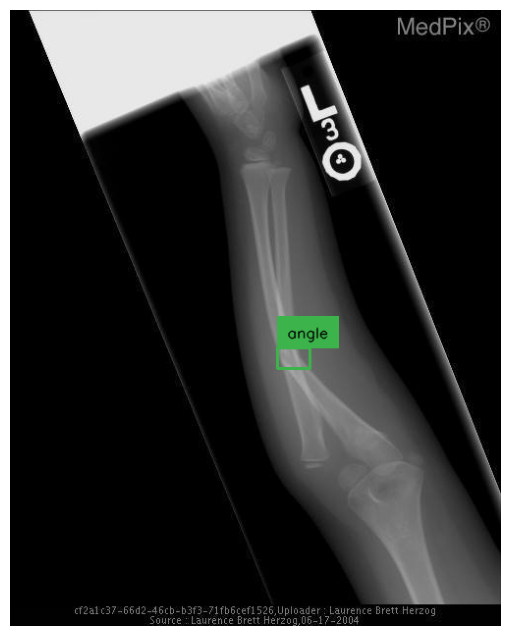

In [ ]:
try:
    categories = TRAIN_DATASET.coco.cats
    id2label = {k: v["name"] for k, v in categories.items()}
    label2id = {v: k for k, v in id2label.items()}
except Exception as e:
    print(f"Could not load categories, please ensure dataset path is correct: {e}")
    # Fallback if dataset isn't loaded yet
    id2label = {
        0: "angle",
        1: "fracture",
        2: "line",
        3: "messed_up_angle",
    }

# Select a random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print(f"Image #{image_id}")

# Load image and annotations
image_info = TRAIN_DATASET.coco.loadImgs(image_id)[0]
coco_annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image_info["file_name"])
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

detections = sv.Detections.from_coco_annotations(coco_annotations)
labels = [f"{id2label[class_id]}" for class_id in detections.class_id]

box_annotator = sv.BoxAnnotator()
annotated_frame = box_annotator.annotate(
    scene=image.copy(), detections=detections, labels=labels
)

sv.plot_image(annotated_frame, (8, 8))

# Creating dataloaders

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        "pixel_values": encoding["pixel_values"],
        "pixel_mask": encoding["pixel_mask"],
        "labels": labels,
    }


TRAIN_DATALOADER = DataLoader(
    dataset=TRAIN_DATASET,
    collate_fn=collate_fn,
    batch_size=4,
    shuffle=True,
)
VAL_DATALOADER = DataLoader(
    dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=4
)
TEST_DATALOADER = DataLoader(
    dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=4
)

This function `collate_fn(batch)` is used in a PyTorch `DataLoader` to **prepare batches of data** for the DETR model during training or evaluation. Let’s break it down line-by-line:

---

### 🔧 Purpose:

PyTorch’s `DataLoader` uses a `collate_fn` to **merge a list of samples** (from your dataset) into a batch. Since each image and annotation may vary in size, especially for detection tasks, this function handles:

* **Padding** images to the same size
* Preparing the **`pixel_mask`** for DETR
* Preserving the variable-length `labels` (bounding boxes and categories)

---

### 🧱 Code Breakdown:

```python
def collate_fn(batch):
```

* `batch`: a list of tuples returned from `__getitem__()` of your dataset.
* Each `item` is: `(pixel_values, target)` where:

  * `pixel_values`: preprocessed image tensor from `DetrImageProcessor`
  * `target`: dictionary with labels/annotations

---

```python
    pixel_values = [item[0] for item in batch]
```

* Extracts just the image tensors (before padding) from the batch.

---

```python
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
```

* Uses Hugging Face’s `DetrImageProcessor.pad()` to:

  * **Pad** the list of images to the same size.
  * Create a **`pixel_mask`**, which tells DETR which parts are actual image and which are padding.
  * Returns a dictionary:

    ```python
    {
        "pixel_values": Tensor of shape (batch_size, 3, H, W),
        "pixel_mask": Tensor of shape (batch_size, H, W)
    }
    ```

---

```python
    labels = [item[1] for item in batch]
```

* Extracts the `labels` (dictionaries containing bounding boxes, class labels, etc.) from each sample.
* DETR expects a **list of `dict`s** — one per image — rather than a tensor, because the number of objects varies per image.

---

### ✅ Final Output:

```python
    return {
        "pixel_values": encoding["pixel_values"],
        "pixel_mask": encoding["pixel_mask"],
        "labels": labels,
    }
```

Returns a dictionary with:

| Key            | Type         | Description                             |
| -------------- | ------------ | --------------------------------------- |
| `pixel_values` | `Tensor`     | Batched and padded images               |
| `pixel_mask`   | `Tensor`     | Mask indicating padded regions          |
| `labels`       | `List[Dict]` | Ground-truth annotations for each image |

---

### 📦 Usage in DataLoader:

This is passed to the `DataLoader` like so:

```python
train_loader = DataLoader(TRAIN_DATASET, batch_size=8, collate_fn=collate_fn)
```

---

### 💡 Why Is This Important for DETR?

* DETR expects **padded images with a mask** (due to its Transformer architecture).
* Standard DataLoader collation would fail on **variable-sized images** and **non-uniform labels**, so this custom `collate_fn` is critical.

# Defining the DETR Model

In [ ]:
from transformers import DetrForObjectDetection

class Detr(pl.LightningModule):
    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        # Load the pre-trained DETR model
        self.model = DetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path="facebook/detr-resnet-50",
            num_labels=len(id2label),
            # This is crucial for fine-tuning on a dataset with a different number of classes
            ignore_mismatched_sizes=True,
        )

        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(
            pixel_values=pixel_values, pixel_mask=pixel_mask
        )

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [
            {k: v.to(self.device) for k, v in t.items()}
            for t in batch["labels"]
        ]

        outputs = self.model(
            pixel_values=pixel_values,
            pixel_mask=pixel_mask,
            labels=labels,
        )

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss)
        for k, v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())

        return loss

    def configure_optimizers(self):
        # As per the DETR paper, the backbone (CNN) should have a lower learning rate
        # than the transformer, which is a common practice in fine-tuning.
        param_dicts = [
            {
                "params": [
                    p
                    for n, p in self.named_parameters()
                    if "backbone" not in n and p.requires_grad
                ]
            },
            {
                "params": [
                    p
                    for n, p in self.named_parameters()
                    if "backbone" in n and p.requires_grad
                ],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(
            param_dicts, lr=self.lr, weight_decay=self.weight_decay
        )

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER

Let's break down this `Detr` class method by method to understand its role and why it's structured this way.

### High-Level Overview

This class, `Detr`, is a wrapper around the Hugging Face `DetrForObjectDetection` model. Its main jobs are:
1.  **Model Definition:** To load the pre-trained DETR model and adapt it for your custom dataset.
2.  **Training Logic:** To define what happens during a single step of training (calculating loss, logging metrics).
3.  **Validation Logic:** To define how the model is evaluated after each training epoch.
4.  **Optimization:** To set up the optimizer with specific learning rates for different parts of the model.

---

### Method-by-Method Explanation

#### `__init__(self, lr, lr_backbone, weight_decay)`
This is the constructor. It runs only once when you create the model object (`model = Detr(...)`).

```python
def __init__(self, lr, lr_backbone, weight_decay):
    super().__init__()
    # Load the pre-trained DETR model
    self.model = DetrForObjectDetection.from_pretrained(
        pretrained_model_name_or_path="facebook/detr-resnet-50",
        num_labels=len(id2label),
        ignore_mismatched_sizes=True,
    )
    # ... store hyperparameters
```

*   `self.model = DetrForObjectDetection.from_pretrained(...)`: This is the most important line. It downloads the DETR model with a ResNet-50 backbone from Hugging Face.
*   `num_labels=len(id2label)`: You are telling the model how many classes your specific dataset has.
*   `ignore_mismatched_sizes=True`: This is **critical for transfer learning**. The original model was trained on 92 classes. This flag tells Hugging Face: "It's okay that my number of classes is different. Please discard the old classification layer (the 'head') and create a new, randomly initialized one that matches my `num_labels`." This is exactly why you saw the "weights mismatch" warning during training, which was a good sign.
*   The rest of the method simply stores the learning rates (`lr`, `lr_backbone`) and `weight_decay` so they can be used later.

#### `forward(self, pixel_values, pixel_mask)`
This method defines what happens during pure inference (when you're not training and just want predictions).

```python
def forward(self, pixel_values, pixel_mask):
    return self.model(
        pixel_values=pixel_values, pixel_mask=pixel_mask
    )
```

*   It's a simple wrapper that passes the inputs directly to the underlying Hugging Face model. When you don't provide `labels`, the model returns raw prediction scores.

#### `common_step(self, batch, batch_idx)`
This is a helper method created by the author to avoid repeating code. It's not a standard PyTorch Lightning method, but it's a very good practice.

```python
def common_step(self, batch, batch_idx):
    # ... unpack batch ...
    labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]
    outputs = self.model(
        pixel_values=pixel_values,
        pixel_mask=pixel_mask,
        labels=labels,
    )
    # ... return loss and loss_dict
```

*   It takes a batch of data, unpacks it, and crucially, moves the `labels` to the correct device (e.g., the GPU).
*   It then calls `self.model` but this time **it includes the `labels`**. When the Hugging Face model receives labels, it automatically calculates the loss for you.
*   `outputs.loss`: This is the final, combined loss value used for backpropagation.
*   `outputs.loss_dict`: This is a dictionary containing the individual components of the loss (e.g., classification loss, L1 bounding box loss, GIoU loss), which is great for detailed monitoring.

#### `training_step(self, batch, batch_idx)`
This is a required PyTorch Lightning method. It defines the complete logic for one forward and backward pass on a single batch of training data.

```python
def training_step(self, batch, batch_idx):
    loss, loss_dict = self.common_step(batch, batch_idx)
    self.log("training_loss", loss)
    for k,v in loss_dict.items():
        self.log("train_" + k, v.item())
    return loss
```

*   It calls `common_step` to get the loss.
*   `self.log(...)`: This is a powerful Lightning feature. It sends the metrics to your logger (like TensorBoard), so you can visualize the training progress in real-time. It logs both the total loss and each individual component.
*   `return loss`: This is essential. The value returned from `training_step` is what PyTorch Lightning uses to perform backpropagation and update the model's weights.

#### `validation_step(self, batch, batch_idx)`
This is another standard Lightning method. It's almost identical to `training_step` but runs on the validation dataset without calculating gradients.

```python
def validation_step(self, batch, batch_idx):
    loss, loss_dict = self.common_step(batch, batch_idx)
    self.log("validation_loss", loss)
    # ... log individual validation losses
    return loss
```

*   Its purpose is to evaluate the model's performance on data it hasn't seen during training. By comparing `training_loss` and `validation_loss`, you can check for overfitting.

#### `configure_optimizers(self)`
This is a required Lightning method where you define your optimizer(s).

```python
def configure_optimizers(self):
    param_dicts = [
        {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
        {"params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad], "lr": self.lr_backbone},
    ]
    return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)
```

*   This implementation uses a very important technique called **differential learning rates**.
*   It splits the model's parameters into two groups:
    1.  The **backbone** (the ResNet-50 part).
    2.  **Everything else** (the Transformer and the new classification head).
*   The backbone is already well-trained, so it's given a very small learning rate (`self.lr_backbone`, e.g., `1e-5`) for gentle fine-tuning.
*   The other parts, especially the new head, need to learn more quickly, so they get a larger learning rate (`self.lr`, e.g., `1e-4`).
*   This is a best practice that leads to more stable and effective fine-tuning.

#### `train_dataloader(self)` and `val_dataloader(self)`
These are simple hooks that tell the `Trainer` where to get the data from. They just return the `DataLoader` objects you defined in a previous cell.

# training

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from pytorch_lightning import Trainer

model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

# Settings for the trainer
# gradient_clip_val is a best practice for training transformers to prevent exploding gradients.
MAX_EPOCHS = 100

trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    gradient_clip_val=0.1,
    accumulate_grad_batches=8,
    log_every_n_steps=5,
)

trainer.fit(model)

config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


This code cell sets up and starts training a **DETR object detection model** using **PyTorch Lightning**. Let’s walk through it line-by-line.

---

## 🔍 **Line-by-Line Explanation**

### ✅ Suppressing Warnings

```python
import warnings
warnings.filterwarnings("ignore")
```

* This hides all warning messages to keep the output clean (useful when logs are too verbose).

---

### 🔥 Model Initialization

```python
from pytorch_lightning import Trainer

model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)
```

* `Detr` is a custom PyTorch Lightning module (probably defined elsewhere).
* It's being initialized with:

  * `lr=1e-4`: learning rate for the main model
  * `lr_backbone=1e-5`: smaller learning rate for the pretrained backbone (ResNet)
  * `weight_decay=1e-4`: regularization to reduce overfitting

> These are common choices for fine-tuning a pretrained Transformer-based model like DETR.

---

### 📌 Set Maximum Epochs

```python
MAX_EPOCHS = 100
```

* Sets the total number of training epochs to 100.

---

### ⚙️ Trainer Configuration

```python
trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    gradient_clip_val=0.1,
    accumulate_grad_batches=8,
    log_every_n_steps=5,
)
```

| Parameter                   | Meaning                                                                                                                 |
| --------------------------- | ----------------------------------------------------------------------------------------------------------------------- |
| `max_epochs=100`            | Train the model for up to 100 epochs                                                                                    |
| `gradient_clip_val=0.1`     | **Gradient clipping**: prevents gradients from exploding (common with Transformers)                                     |
| `accumulate_grad_batches=8` | **Gradient accumulation**: simulates larger batch size by accumulating gradients over 8 batches before updating weights |
| `log_every_n_steps=5`       | Logs metrics every 5 training steps                                                                                     |

> This setup is **memory-efficient** and **stabilizes training**, especially for larger models like DETR.

---

### 🚀 Start Training

```python
trainer.fit(model)
```

* Begins training the model using the training/validation DataLoaders defined inside your `Detr` module.
* PyTorch Lightning handles:

  * Forward/backward pass
  * Logging
  * Validation steps
  * Device placement (CPU/GPU)

---

## ✅ Summary

This cell:

* Initializes a DETR object detection model
* Configures a PyTorch Lightning `Trainer` with best practices for Transformer models
* Starts training with logging and stability features (gradient clipping & accumulation)

---

It seems completely counter-intuitive to see `eval` mode when you're starting to train.

However, for this specific architecture (DETR with a ResNet backbone), **this is not only correct but is actually a crucial best practice for successful fine-tuning.**

Here’s the detailed breakdown of why:

### The Role of Batch Normalization

1.  **The Backbone:** Your DETR model uses a pre-trained ResNet-50 as its "backbone" to see and process the image. ResNet models are filled with **Batch Normalization** (`BatchNorm`) layers.

2.  **How BatchNorm Works:**
    *   **In `train` mode:** A BatchNorm layer calculates the mean and variance of the *current batch* of data to normalize it. It also keeps a running average of the means and variances it has seen over time.
    *   **In `eval` mode:** The BatchNorm layer *freezes*. It stops calculating statistics from the current batch and instead uses the stable, long-term *running averages* it learned during its original pre-training.

### Why `eval` Mode is Better for Fine-Tuning the Backbone

The ResNet backbone was pre-trained on a massive, diverse dataset (like COCO or ImageNet). Its BatchNorm layers have learned very robust and general-purpose statistics for what features in an image should look like.

When you fine-tune on your smaller, more specific dataset (bone fractures), your batches are small and less diverse. If you were to put the backbone's BatchNorm layers into `train` mode:
*   The noisy statistics from your small batches would start to "pollute" the very good, stable running averages that the model already learned.
*   This can destabilize the training process and lead to worse performance.

By keeping the backbone in **`eval` mode**, you freeze its BatchNorm layers. They continue to use their high-quality, pre-trained statistics to normalize the features, providing a stable foundation for the rest of the model (the Transformer part) to learn effectively on your new data.

### What the Log is Telling You

The PyTorch Lightning summary is very precise:

```
  | Name  | Type                   | Params | Mode
--------------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M | eval
--------------------------------------------------------
...
0         Modules in train mode
399       Modules in eval mode
```

This shows that the vast majority of the model's modules (the 399 modules that make up the ResNet backbone) are intentionally kept in `eval` mode.

**Crucially, "eval mode" does not mean the weights are frozen!** The model's **41.3 M trainable parameters** are still having their gradients calculated and are being updated by the optimizer. The `mode` only controls the behavior of specific layers like BatchNorm and Dropout.

**In short: You are correct, the model is in `eval` mode. And for this specific fine-tuning task, that is the correct and intended behavior for achieving the best results.** It's a sophisticated technique that the Hugging Face `transformers` library and PyTorch Lightning handle for you automatically.

# model saving

In [ ]:
MODEL_PATH = "bone_fracture_detr_model"

# The `save_pretrained` method saves the model's configuration and weights.
model.model.save_pretrained(MODEL_PATH)

print(f"Model saved to {MODEL_PATH}")

Model saved to bone_fracture_detr_model


In [ ]:
!zip -r /content/bone_fracture_detr_model.zip /content/bone_fracture_detr_model

  adding: content/bone_fracture_detr_model/ (stored 0%)
  adding: content/bone_fracture_detr_model/model.safetensors (deflated 7%)
  adding: content/bone_fracture_detr_model/config.json (deflated 62%)


# single image inference

In [ ]:
# Create a mapping from filename to image_id for easy lookup
filename_to_id_map = {
    img_info["file_name"]: img_id
    for img_id, img_info in TEST_DATASET.coco.imgs.items()
}

In [ ]:
def infer_and_compare(
    image_path,
    coco_dataset,
    filename_map,
    model,
    processor,
    device,
    id2label,
    confidence_threshold=0.25,
):
    """
    Runs inference on a single image file and displays the result
    side-by-side with its ground truth.
    """
    try:
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Could not read image at {image_path}")
            return
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    except Exception as e:
        print(f"Error loading image: {e}")
        return

    box_annotator = sv.BoxAnnotator()

    # --- 1. ANNOTATE GROUND TRUTH ---
    file_name = os.path.basename(image_path)
    image_id = filename_map.get(file_name)

    if image_id is None:
        print(f"Could not find ground truth for {file_name}")
        return

    gt_annotations = coco_dataset.coco.imgToAnns[image_id]
    gt_detections = sv.Detections.from_coco_annotations(gt_annotations)
    gt_labels = [f"{id2label[class_id]}" for class_id in gt_detections.class_id]
    frame_ground_truth = box_annotator.annotate(
        scene=image_rgb.copy(), detections=gt_detections, labels=gt_labels
    )

    # --- 2. ANNOTATE PREDICTIONS (INFERENCE) ---
    with torch.no_grad():
        inputs = processor(images=image_rgb, return_tensors="pt").to(device)
        outputs = model(**inputs)
        target_sizes = torch.tensor([image_rgb.shape[:2]]).to(device)
        results = processor.post_process_object_detection(
            outputs=outputs,
            threshold=confidence_threshold,
            target_sizes=target_sizes,
        )[0]

    detections = sv.Detections.from_transformers(
        transformers_results=results
    )

    labels = [
        f"{id2label[class_id]} {confidence:.2f}"
        for confidence, class_id in zip(
            detections.confidence, detections.class_id
        )
    ]
    frame_detections = box_annotator.annotate(
        scene=image_rgb.copy(), detections=detections, labels=labels
    )

    # --- 3. DISPLAY SIDE-BY-SIDE ---
    sv.plot_images_grid(
        images=[frame_ground_truth, frame_detections],
        grid_size=(1, 2),
        titles=["Ground Truth", "Prediction"],
    )

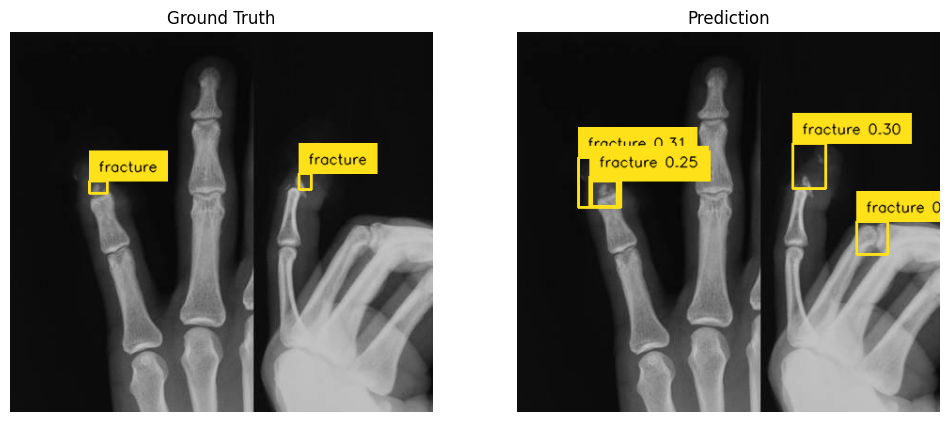

In [ ]:
MODEL_PATH = "bone_fracture_detr_model"
NEW_IMAGE_PATH = "/content/bone_fracture_dataset/test/90_jpg.rf.7163e0a2586c369f8cb72f1cdc305d52.jpg"

inference_model = DetrForObjectDetection.from_pretrained(MODEL_PATH)
inference_model.to(DEVICE)

if os.path.exists(NEW_IMAGE_PATH):
    infer_and_compare(
        image_path=NEW_IMAGE_PATH,
        coco_dataset=TEST_DATASET,
        filename_map=filename_to_id_map,
        model=inference_model,
        processor=image_processor,
        device=DEVICE,
        id2label=id2label,
    )
else:
    print(
        f"File not found: '{NEW_IMAGE_PATH}'. Please upload an image and update the path."
    )

## The current results are suboptimal, which is attributable to an insufficient number of training epochs. We anticipate that extending the training period will lead to a considerable improvement in model accuracy.